In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Открытие данных

In [2]:
diabetes_df = pd.read_csv('new_diabetes.csv', sep=',')

In [3]:
diabetes_df.head()

,Pegnancy_count,Glucose,Pressure,Thickness_of_skin_fold,Insulin,BMI,Pedigree_diabetes_function,Age,Diabetes_prediction
0,6,148.0,72.0,35.0,120.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,120.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,120.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5,116.0,74.0,29.0,120.0,25.6,0.201,30,0


In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pegnancy_count              656 non-null    int64  
 1   Glucose                     656 non-null    float64
 2   Pressure                    656 non-null    float64
 3   Thickness_of_skin_fold      656 non-null    float64
 4   Insulin                     656 non-null    float64
 5   BMI                         656 non-null    float64
 6   Pedigree_diabetes_function  656 non-null    float64
 7   Age                         656 non-null    int64  
 8   Diabetes_prediction         656 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 46.2 KB


In [4]:
diabetes_df.Diabetes_prediction.value_counts()

0    443
1    213
Name: Diabetes_prediction, dtype: int64

## Деление на тренировку и тест

In [8]:
X = diabetes_df.drop('Diabetes_prediction', axis=1).values
y = diabetes_df.Diabetes_prediction.values

In [9]:
X.shape, y.shape

((656, 8), (656,))

In [16]:
# Делаем разделение с учетом дисбаланса классов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Моделлинг

In [22]:
clf = LogisticRegression(random_state=42)
scaler = StandardScaler().fit(X_train)

In [23]:
X_train = scaler.transform(X_train)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [68]:
clf.coef_, clf.intercept_

(array([[ 0.35707483,  1.18929252, -0.05841898,  0.06781018,  0.01313319,
          0.6099991 ,  0.2410352 ,  0.18800994]]),
 array([-1.03619323]))

## Оценка модели

In [26]:
X_test = scaler.transform(X_test)

In [29]:
predicts = clf.predict(X_test)

In [33]:
accuracy_score(y_test, predicts)

0.803030303030303

In [30]:
confusion_matrix(y_test, predicts)

array([[80,  9],
       [17, 26]], dtype=int64)

In [31]:
precision_score(y_test, predicts)

0.7428571428571429

In [32]:
recall_score(y_test, predicts)

0.6046511627906976

Значение точности 0.74 означает, что из всех людей, кого модель обрекла на диабет, лишь 74 процента из них реально получили диабет.

Значение полноты 0.60 показывает, что из всех, у кого появился диабет, модель обнаружила только 60 процентов

В этой задаче мы хотим находить как можно больше людей, которые заболеют, то есть нам нужно максимизировать полноту, но так, чтобы точность не упала ниже хотя бы 60 процентов

In [39]:
# Получение вероятностей принадлежности классу 1
predicts_proba = clf.predict_proba(X_test)[:, 1]

In [40]:
def threshold(probs, thresh=0.5):
    new_probs = probs.copy()
    new_probs[new_probs > thresh] = 1
    new_probs[new_probs <= thresh] = 0
    return new_probs

In [44]:
predicts = threshold(predicts_proba, 0.31)
print("Precision " + str(precision_score(y_test, predicts)))
print("Recall " + str(recall_score(y_test, predicts)))

Precision 0.603448275862069
Recall 0.813953488372093


Модель с таким порогом нас удовлетворяет, но порог пришлось искать вручную. Изобразим график PR-кривой и посмотрим, на что мы еще могли расчитывать

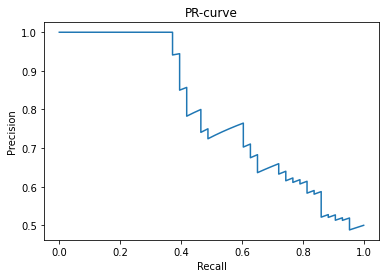

In [48]:
p_array, r_array, thresholds = precision_recall_curve(y_test, predicts_proba)
plt.plot(r_array, p_array)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curve')
plt.show()

In [60]:
print("Площадь под графиком: " + str(auc(r_array, p_array)))

Площадь под графиком: 0.788420471630007


Найдем оптимальный порог, учитывая что максимизировать мы должны полноту, а точность брать не менее 0.6

In [50]:
p_idx = np.where(p_array >= 0.6)
p_idx

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86], dtype=int64),)

In [51]:
r_array[p_idx]

array([0.81395349, 0.81395349, 0.79069767, 0.79069767, 0.76744186,
       0.76744186, 0.74418605, 0.74418605, 0.74418605, 0.72093023,
       0.72093023, 0.72093023, 0.69767442, 0.6744186 , 0.65116279,
       0.65116279, 0.65116279, 0.65116279, 0.62790698, 0.62790698,
       0.62790698, 0.60465116, 0.60465116, 0.60465116, 0.60465116,
       0.58139535, 0.55813953, 0.53488372, 0.51162791, 0.48837209,
       0.48837209, 0.46511628, 0.46511628, 0.46511628, 0.44186047,
       0.41860465, 0.41860465, 0.41860465, 0.39534884, 0.39534884,
       0.39534884, 0.37209302, 0.37209302, 0.34883721, 0.3255814 ,
       0.30232558, 0.27906977, 0.25581395, 0.23255814, 0.20930233,
       0.18604651, 0.1627907 , 0.13953488, 0.11627907, 0.09302326,
       0.06976744, 0.04651163, 0.02325581, 0.        ])

In [57]:
t = thresholds[27]
predicts = threshold(predicts_proba, t)
print("t: " + str(t))
print("Precision: " + str(precision_score(y_test, predicts)))
print("Recall: " + str(recall_score(y_test, predicts)))

t: 0.3097636845497932
Precision: 0.603448275862069
Recall: 0.813953488372093


Как видим, получился такой же результат, но без ручного перебора

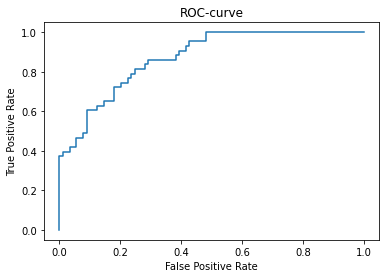

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, predicts_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [65]:
print("Площадь под графиком: " + str(auc(fpr, tpr)))

Площадь под графиком: 0.8706558662137444


Не смотря на большое значение площади под ROC-кривой, следует помнить, что эта метрика может ввести в заблуждение из-за несбалансированности класса